<a href="https://colab.research.google.com/github/Putranto13/Tugas_Machine_Learning/blob/main/Week9_4_4_Model_Selection%2C_Underfitting%2C_and_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==0.17.0

     |████████████████████████████████| 83 kB 756 kB/s 


In [2]:
import math
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [3]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [4]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [tf.constant(x, dtype=
    tf.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 1.7450638],
        [-1.0809073]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[ 1.0000000e+00,  1.7450638e+00,  1.5226238e+00,  8.8569182e-01,
          3.8639718e-01,  1.3485754e-01,  3.9222501e-02,  9.7779660e-03,
          2.1328968e-03,  4.1356010e-04,  7.2168870e-05,  1.1449026e-05,
          1.6649400e-06,  2.2349434e-07,  2.7857990e-08,  3.2409313e-09,
          3.5347697e-10,  3.6284697e-11,  3.5177282e-12,  3.2308737e-13],
        [ 1.0000000e+00, -1.0809073e+00,  5.8418030e-01, -2.1048160e-01,
          5.6877773e-02, -1.2295920e-02,  2.2151251e-03, -3.4204926e-04,
          4.6215446e-05, -5.5505125e-06,  5.9995898e-07, -5.8954548e-08,
          5.3103668e-09, -4.4153958e-10,  3.4090241e-11, -2.4565593e-12,
          1.6595706e-13, -1.0552012e-14,  6.3365259e-16, -3.6048409e-17]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([6.9683414 , 0.35564628], dtyp

In [5]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

weight: [[ 4.9957633  1.273323  -3.4214814  5.451409 ]]


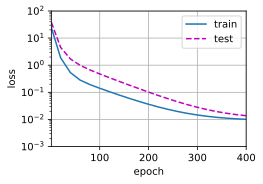

In [7]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.5662935 3.410458 ]]


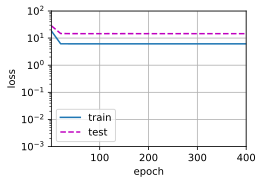

In [8]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.962509    1.2848129  -3.2528734   5.2504015  -0.46592033  0.9389179
  -0.10215175  0.17181647 -0.03741352  0.00738309 -0.35371187 -0.10836661
   0.16848938  0.17742556 -0.40267965 -0.46570852 -0.13057065 -0.42408824
   0.1648106   0.20914412]]


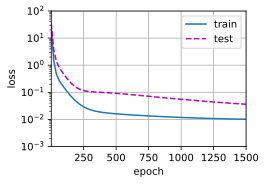

In [9]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)